In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma.core import squeeze
from channel_simulation import generate_channels_new
from ao_algorithm import ao_algorithm
from optimizers import optimize_omega_sca, ga_optimize_omega, pso_optimize_omega, no_optimize_omega, optimize_omega_sca,optimize_omega_sca_2nd_bound
import torch
from location import location

# ====================== 超参数设置 ======================
K = 20 #用户数量
N = 100 # RIS 元素数量
sigma_a2 = 10  # AP 端噪声方差
max_iter = 50  # 最大迭代次数
tol = 1e-6  # 收敛阈值
alpha_min = 0.2  # RIS 反射系数的最小值
phi = 0.0  # 相位偏移参数
gamma_param = 3.0  # 控制函数曲线陡度的参数
P_k = np.ones(K)*1  # 每个用户的发射功率约束，假设都为1

# GA参数
population_size = 80  # 种群规模
num_generations = 100  # 迭代代数
crossover_rate = 0.8  # 交叉率
mutation_rate = 0.3  # 变异率

# PSO参数
num_particles = 200  # 粒子数量
max_iterations_pso = 200  # PSO最大迭代次数
w = 0.7  # 惯性权重
c1 = 3.0  # 个体加速因子
c2 = 3.0  # 社会加速因子

# 设置中文字体以避免Matplotlib的字体警告
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子，确保可重复性
np.random.seed(2024)
torch.manual_seed(2024)

pl_RA, pl_UA, dis_RA, dis_UA, location_user = location(K)
location_AP = np.array([-50, 0, 12])
location_RIS = np.array([0, 0, 12])
h, g = generate_channels_new(N, K, pl_RA, pl_UA, location_user, location_AP, location_RIS)
g = g.squeeze()

print(f"信道矩阵 h 的形状：{h.shape}")
print(f"信道向量 g 的形状：{g.shape}")

# 初始化变量
eta_init = 1.0
b_init = np.sqrt(P_k) * np.exp(1j * 2 * np.pi * np.random.rand(K))
omega_init = np.random.uniform(low=-np.pi, high=np.pi, size=N)

# GA优化
print("运行使用 GA 优化 omega_n 的 AO 算法...")
omega_opt = ga_optimize_omega(h=h, g=g, eta=eta_init, b=b_init, omega_old=omega_init,
                            alpha_min=alpha_min, phi=phi, gamma_param=gamma_param,
                            sigma_a2=sigma_a2, population_size=population_size,
                            num_generations=num_generations, crossover_rate=crossover_rate,
                            mutation_rate=mutation_rate)

print("使用GA找到的最佳相位进行AO优化...")
eta_opt_ga, b_opt_ga, omega_opt_ga, mse_list_ga = ao_algorithm(h=h, g=g, eta_init=eta_init,
    b_init=b_init, omega_init=omega_opt, P_k=P_k, sigma_a2=sigma_a2, alpha_min=alpha_min,
    phi=phi, gamma_param=gamma_param, optimize_omega_func=no_optimize_omega,
    max_iter=max_iter, tol=tol)


# SCA优化
print("运行使用 sca 优化 omega_n 的 AO 算法...")
eta_opt_sca, b_opt_sca, omega_opt_sca, mse_list_sca = ao_algorithm(h=h, g=g,
    eta_init=eta_init, b_init=b_init, omega_init=omega_init, P_k=P_k,
    sigma_a2=sigma_a2, alpha_min=alpha_min, phi=phi, gamma_param=gamma_param,
    optimize_omega_func=optimize_omega_sca, max_iter=max_iter, tol=tol)



# PSO优化
print("运行使用 PSO 优化 omega_n 的 AO 算法...")
omega_opt_pso = pso_optimize_omega(h=h, g=g, eta=eta_init, b=b_init,
    omega_old=omega_init, alpha_min=alpha_min, phi=phi, gamma_param=gamma_param,
    sigma_a2=sigma_a2, num_particles=num_particles, max_iterations=max_iterations_pso,
    w=w, c1=c1, c2=c2)

print("使用PSO找到的最佳相位进行AO优化...")
eta_opt_pso, b_opt_pso, omega_opt_pso, mse_list_pso = ao_algorithm(h=h, g=g,
    eta_init=eta_init, b_init=b_init, omega_init=omega_opt_pso, P_k=P_k,
    sigma_a2=sigma_a2, alpha_min=alpha_min, phi=phi, gamma_param=gamma_param,
    optimize_omega_func=no_optimize_omega, max_iter=max_iter, tol=tol)



# 不优化
print("运行不优化 omega_n 的 AO 算法...")
eta_opt_no, b_opt_no, omega_opt_no, mse_list_no = ao_algorithm(h=h, g=g,
    eta_init=eta_init, b_init=b_init, omega_init=omega_init, P_k=P_k,
    sigma_a2=sigma_a2, alpha_min=alpha_min, phi=phi, gamma_param=gamma_param,
    optimize_omega_func=no_optimize_omega, max_iter=max_iter, tol=tol)




信道矩阵 h 的形状：(100, 20)
信道向量 g 的形状：(100,)
运行使用 GA 优化 omega_n 的 AO 算法...
使用GA找到的最佳相位进行AO优化...
运行使用 sca 优化 omega_n 的 AO 算法...


2025-02-23 21:28:31,868 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 3.0, 'c2': 3.0, 'w': 0.7}


运行使用 PSO 优化 omega_n 的 AO 算法...


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0.00674
2025-02-23 21:30:21,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0067368790977347, best pos: [ 1.65207383  1.94905494 -1.44484741  2.20112011  1.38872119  0.58545193
  1.07815851  1.28748114 -1.02572333 -0.00985884  1.75495702  0.38256558
  1.05365198 -1.52659912 -2.89563393  1.27446175 -0.63484695  2.20170649
 -1.90433801  0.23562892 -2.23833091  1.12743714 -1.80150217  0.8205481
  1.19340139  1.43684195 -2.34022464 -2.67522746  0.93770512  0.69496139
 -0.48753305  2.56075949  1.70451188  2.19158321  1.44583192 -2.77088458
  0.46184368 -1.74688249 -0.84234721 -2.85661663  2.27344665 -2.72464055
 -1.39425557  0.97781968  2.98675296 -2.95784188  1.0917641   1.43294049
 -1.06485605  1.39504861 -2.68909511  1.25057834  0.76619433 -0.78544507
  2.37562921 -0.26833485 -2.43755351 -1.8102033   1.22226958  1.56699278
 -1.50937061 -0.74145869  2.44509281  1.71496183 -0.91044296  0.8076016

使用PSO找到的最佳相位进行AO优化...
运行不优化 omega_n 的 AO 算法...


不优化 omega 的最终 MSE: 0.04454412525805765
PSO 优化的最终 MSE: 0.016006063460487937
SCA 优化的最终 MSE: 0.011832668589972017
GA 优化的最终 MSE: 0.004795151126358314


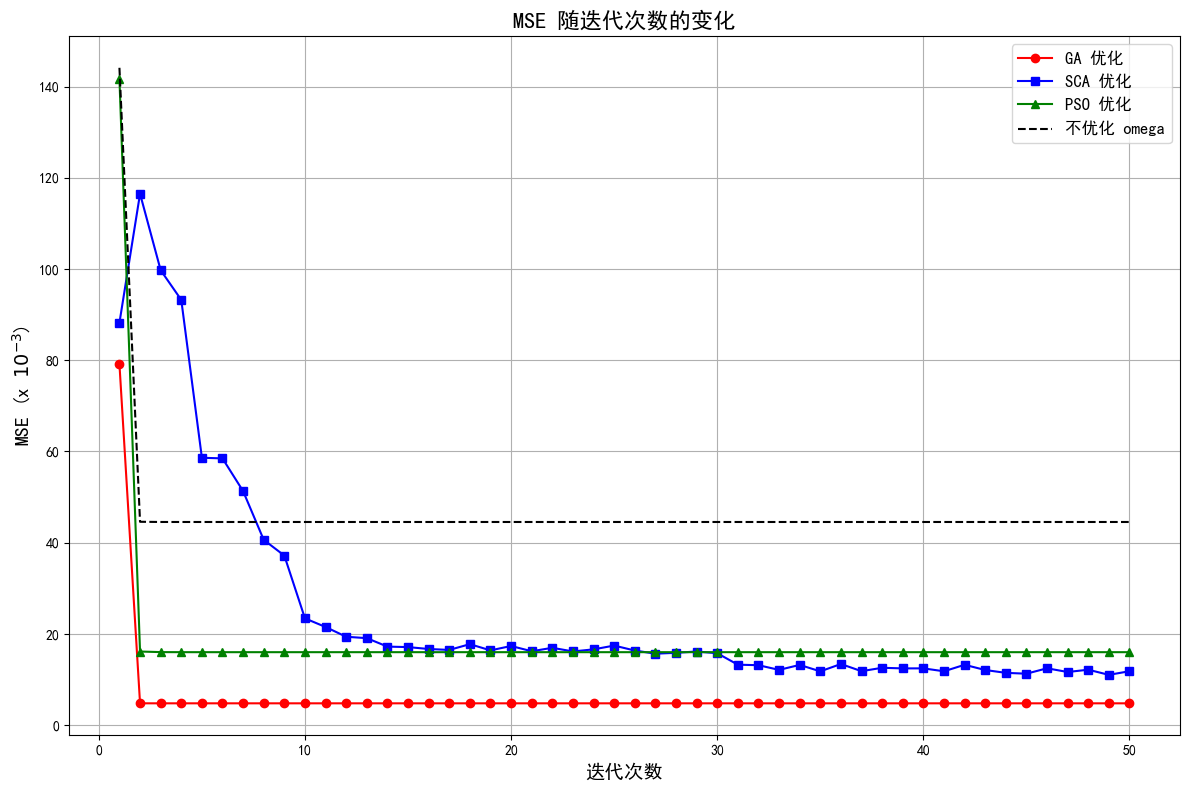

[0.08820366645073525, 0.1164923803491537, 0.09973825084551316, 0.09322300394134446, 0.058623786814448395, 0.058483015980426295, 0.051304389057561, 0.04063222249895722, 0.0371760836524792, 0.023415014585980574, 0.021527952285182214, 0.0193860439215394, 0.019080928982883733, 0.017227060991908648, 0.01711991603203558, 0.01670642497652788, 0.016498261307400675, 0.01776233759545346, 0.016401204520240038, 0.01736224861167436, 0.01620829669374466, 0.0169658361521014, 0.016165920293325673, 0.01662271263388044, 0.017452475959569162, 0.016365685293178056, 0.015675741974356384, 0.01586808345832019, 0.016153809936524162, 0.015777641945688183, 0.013264302466412307, 0.013150807047190937, 0.012124941532015978, 0.013213983717657187, 0.011802454379755346, 0.01341006788918786, 0.01184067940355369, 0.012586269783419382, 0.012449687857258666, 0.012458228882107767, 0.01181460392068863, 0.013240865256454373, 0.012096173499444042, 0.011475767665825967, 0.011287827034664744, 0.012472591768378168, 0.0116605863

In [3]:
print(f"不优化 omega 的最终 MSE: {mse_list_no[-1]}")
print(f"PSO 优化的最终 MSE: {mse_list_pso[-1]}")
print(f"SCA 优化的最终 MSE: {mse_list_sca[-1]}")
print(f"GA 优化的最终 MSE: {mse_list_ga[-1]}")
# 绘制MSE随迭代次数的变化曲线
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(mse_list_ga) + 1), [x * 1000 for x in mse_list_ga], 'r-o', label='GA 优化')
plt.plot(range(1, len(mse_list_sca) + 1), [x * 1000 for x in mse_list_sca], 'b-s', label='SCA 优化')
plt.plot(range(1, len(mse_list_pso) + 1), [x * 1000 for x in mse_list_pso], 'g-^', label='PSO 优化')
plt.plot(range(1, len(mse_list_no) + 1), [x * 1000 for x in mse_list_no], 'k--', label='不优化 omega')
plt.xlabel('迭代次数', fontsize=14)
plt.ylabel('MSE (x $10^{-3}$)', fontsize=14)
plt.title('MSE 随迭代次数的变化', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
print(mse_list_sca)
